Things to explore/do here:

- [x] make some slice plots of the function that we are interpolating. how noisy is it currently?
- [x] jax interpolation. without jax interpolation, everything is for naught because it'll be slow.
- [ ] unit tests for jax interpolation. this is simple since we can just compare against scipy.
- [ ] real code!! not just a janky example.
- [ ] unstructured interpolation grids that are higher density in regions where that's necessary. We could start by dividing the domain into just a few hyper-triangles and then divide only those triangles where the edge midpts/center are substantially different from the existing vertices. This might be necessary fairly early because it seems like the function we're interpolating can have dramatic changes in value with respect to the input space.

In [1]:
import outlaw.nb_util as nb_util
nb_util.setup_nb()

In [2]:
import scipy.interpolate
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import lewis

/Users/tbent/.mambaforge/envs/confirm/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
params = {
    "n_arms" : 4,
    "n_stage_1" : 10,
    "n_stage_2" : 10,
    "n_interims" : 3,
    "n_add_per_interim" : 4,
    "futility_threshold" : 0.1,
    "pps_threshold_lower" : 0.1,
    "pps_threshold_upper" : 0.9,
    "posterior_difference_threshold" : 0.05,
    "rejection_threshold" : 0.05,
    "n_pr_sims" : 100,
    "n_sig2_sim" : 20,
    "batch_size" : 2**17,
}

LL = lewis.Lewis45(**params)

In [4]:
(
    LL.n_configs_max_mask,
    LL.n_configs_ph2,
    LL.n_configs_ph3,
    LL.hashes_ph2,
    LL.hashes_ph3,
    LL.offsets_ph2,
    LL.offsets_ph3,
) = LL.n_configs_setting__()

In [5]:
ns = LL.n_configs_ph3[0]
all_data = LL.table_data__(
    ns, jnp.meshgrid(*(jnp.arange(0, n + 1) for n in ns), indexing="ij")
)
data = all_data[10000]

In [6]:
y = data[:, 0]
n = data[:, 1]
print(y, n)

[ 0 18 20 18] [20 20 22 22]


In [7]:
hashes = LL.hashes_ph3
offsets = LL.offsets_ph3
LL.posterior_difference_table[LL.hash__(y, n, LL.hashes_ph3, LL.offsets_ph3)]

DeviceArray([0.00621347, 0.00417244, 0.0788037 ], dtype=float64)

In [8]:
def get_index(y, n):
    return y[-1] + jnp.sum(jnp.flip(y[:-1]) * jnp.cumprod(n + 1)[:-1])
table_n0 = LL.posterior_difference_table[:LL.offsets_ph3[1]]
table_n0[get_index(y, n)]

DeviceArray([0.00621347, 0.00417244, 0.0788037 ], dtype=float64)

In [9]:
LL.posterior_difference_table[LL.hash__(y, n, LL.hashes_ph3, LL.offsets_ph3)]

DeviceArray([0.00621347, 0.00417244, 0.0788037 ], dtype=float64)

In [10]:
yi_range = [jnp.arange(0, ni + 1, 2) for ni in n]
yi_grid = jnp.meshgrid(*yi_range, indexing="ij")
y_grid_1d = jnp.stack(yi_grid, axis=-1).reshape((-1, 4))
y_grid_1d.shape

(17424, 4)

In [11]:
get_idx_vmap = jax.vmap(get_index, in_axes=(0, None))
table_idx = get_idx_vmap(y_grid_1d, n)
subset_table_n0 = table_n0[table_idx].reshape((*yi_grid[0].shape, 3))
subset_table_n0.shape

(11, 11, 12, 12, 3)

Does the interpolation result match the mean of the corners of the zone that the lookup point is in?

Yes! This is exactly as we'd expect from a linear interpolation.

In [12]:
y_test = np.array([[14, 14, 11, 11]])
print(f"n={n}, table y={table_n0[get_idx_vmap(y_test, n)]}")
print(
    f"corners="
    f"\n{table_n0[get_idx_vmap(np.array([[14, 14, 10, 10]]), n)]}"
    f"\n{table_n0[get_idx_vmap(np.array([[14, 14, 12, 10]]), n)]}"
    f"\n{table_n0[get_idx_vmap(np.array([[14, 14, 12, 12]]), n)]}"
    f"\n{table_n0[get_idx_vmap(np.array([[14, 14, 10, 12]]), n)]}"
)
interp_vals = np.array(
    [
        scipy.interpolate.interpn(yi_range, subset_table_n0[..., d], y_test)[0]
        for d in range(3)
    ]
)
print(f"interp={interp_vals}")

print('what would we expect from the mean??', np.mean([
    table_n0[get_idx_vmap(np.array([[14, 14, 10, 10]]), n)],
    table_n0[get_idx_vmap(np.array([[14, 14, 12, 10]]), n)],
    table_n0[get_idx_vmap(np.array([[14, 14, 12, 12]]), n)],
    table_n0[get_idx_vmap(np.array([[14, 14, 10, 12]]), n)],
], axis=0))

n=[20 20 22 22], table y=[[0.96856094 0.77199198 0.01656539]]
corners=
[[0.96988088 0.76734262 0.99532791]]
[[0.94371537 0.67245688 0.16150592]]
[[0.96115625 0.67331749 0.03090288]]
[[0.95858466 0.75185198 0.9987251 ]]
interp=[0.95833429 0.71624224 0.54661545]
what would we expect from the mean?? [[0.95833429 0.71624224 0.54661545]]


In [13]:
def f(y):
    plot_data = np.stack((y, np.tile(n[None,:], (y.shape[0], 1))), axis=-1)
    out = jax.vmap(LL.posterior_difference)(plot_data)
    return out.reshape((y.shape[0], out.shape[-1]))

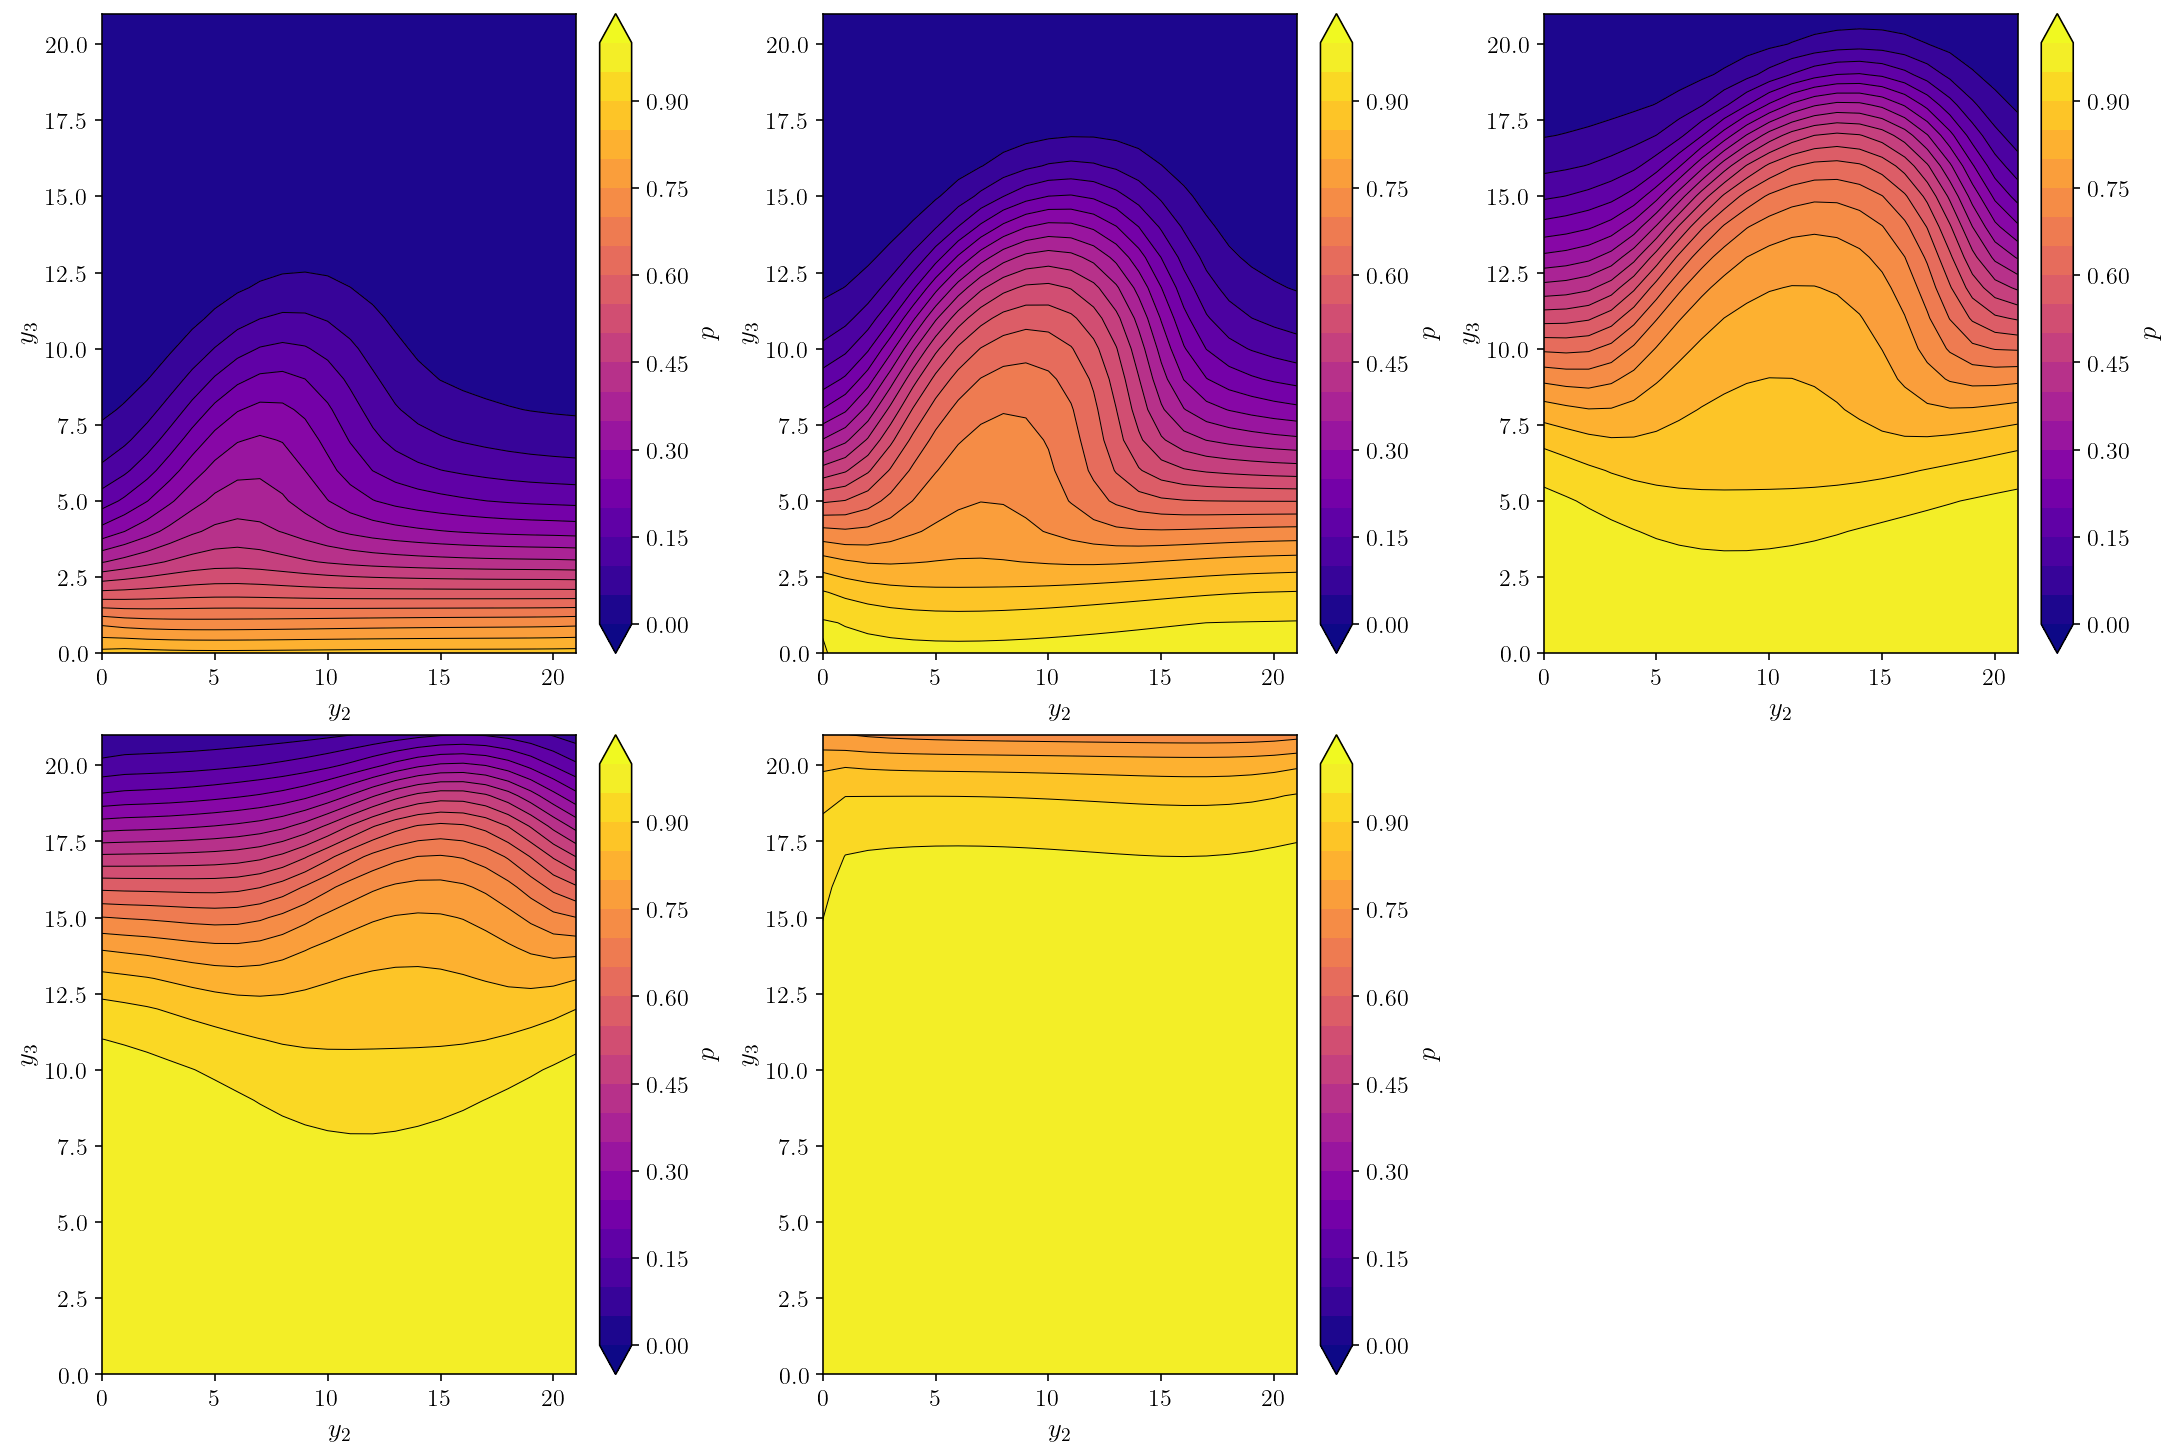

In [14]:
plt.figure(figsize=(15, 10), constrained_layout=True)
for i, y0 in enumerate([2, 5, 10, 15, 20]):
    plt.subplot(2, 3, i + 1)
    y1 = 10
    y2 = np.arange(0, ns[2])
    y3 = np.arange(0, ns[3])
    yplot_grid = jnp.meshgrid(y2, y3, indexing="ij")
    yplot_grid1d = np.stack(yplot_grid, axis=-1).reshape((-1, 2))
    nplot = yplot_grid1d.shape[0]
    yplot_grid1d = np.concatenate((np.full((nplot, 1), y0), np.full((nplot, 1), y1), yplot_grid1d), axis=-1)
    Aplot = f(yplot_grid1d)[:,3].reshape(yplot_grid[0].shape)
    # plot_data = np.stack((yplot_grid1d, np.tile(n[None,:], (yplot_grid1d.shape[0], 1))), axis=-1)
    # Aplot = jax.vmap(LL.posterior_difference)(plot_data)[:,3].reshape(yplot_grid[0].shape)

    levels=np.linspace(0, 1, 21)
    _, cbar = nb_util.contourf_tbt(yplot_grid[0], yplot_grid[1], Aplot, levels=levels)
    plt.xlabel('$y_2$')
    plt.ylabel('$y_3$')
    cbar.set_label('$p$')
plt.show()

In [15]:
# LL.posterior_difference(np.stack((yplot_grid1d[100], n), axis=-1))
# table_n0[get_index(yplot_grid1d[100], n)]
coords = jnp.meshgrid(*(jnp.arange(0, n + 1) for n in ns), indexing="ij")
GG = np.stack(coords, axis=-1).reshape((-1, 4))
yfunny = yplot_grid1d[100]
idx1 = LL.hash__(yfunny, n, LL.hashes_ph3, LL.offsets_ph3)
idx2 = get_index(yfunny, n)
yfunny, n, [idx1], GG[idx2]

(array([20, 10,  4, 12]),
 DeviceArray([20, 20, 22, 22], dtype=int64),
 [DeviceArray(207366, dtype=int64)],
 array([18, 13, 22, 21]))

In [16]:
# interp_pts = yi_range
# grid = tuple([np.asarray(p) for p in interp_pts])
# x_nd = np.stack(np.meshgrid(*grid, indexing="ij"), axis=-1)
# x = x_nd.reshape((-1, 4))
# values = f(x)[:,0].reshape(x_nd.shape[:-1])
# interp_vals = subset_table_n0[..., 0]
# lookup_pts = y_test

In [17]:
from outlaw.interp import interpn    

x_nd = np.stack(np.meshgrid(*yi_range, indexing="ij"), axis=-1)
x = x_nd.reshape((-1, 4))
values = f(x)[:,0].reshape(x_nd.shape[:-1])
interpn(yi_range, values, y_test[:1])

DeviceArray([0.73945459], dtype=float64)

In [23]:
N = int(1e6) // y_test.shape[0]
y_test = np.tile(y_test, (N, 1))

In [25]:
%%timeit
_ = interpn(yi_range, values, y_test)

69.2 ms ± 1e+03 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
%%time
scipy.interpolate.interpn(yi_range, values, y_test)

CPU times: user 408 ms, sys: 244 ms, total: 652 ms
Wall time: 474 ms


array([0.73945459, 0.73945459, 0.73945459, 0.73945459, 0.73945459, 0.73945459, 0.73945459,
       0.73945459, 0.73945459, 0.73945459, ..., 0.73945459, 0.73945459, 0.73945459, 0.73945459,
       0.73945459, 0.73945459, 0.73945459, 0.73945459, 0.73945459, 0.73945459])